In [75]:
import json
import requests
import datetime as dt
import numpy as np
import pandas as pd
# defining key/request url
from binance.client import Client
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

In [1]:
#Getting data for last year

In [3]:
api_key='hKmlFuyZiyNlaN6ARvCKnhF5owS6yrVJolMeSBfThE5Hc6L26aRM2Z3N8EuVQf0y'
secret_key='B4c5Cr9vwsubR19XK05axHk6aSGhnP91GdXLY57LlaYoUNMf4s5egKIHhtgfJYAd'

In [7]:
str((dt.datetime.now() - dt.timedelta(days=2)).date()), str(dt.datetime.now().date())

('2023-07-16', '2023-07-18')

In [4]:
client = Client(api_key, secret_key)

In [67]:
df= pd.DataFrame(client.get_historical_klines('BTCUSDT','1d',
                                              str((dt.datetime.now() - dt.timedelta(weeks=52))),
                                              str((dt.datetime.now()))))
df

,0,1,2,3,4,5,6,7,8,9,10,11
0,1658275200000,23398.48000000,24276.74000000,22906.19000000,23223.30000000,238762.17094000,1658361599999,5631801151.22037560,6364038,119820.55352000,2826789486.16930980,0
1,1658361600000,23223.30000000,23442.77000000,22341.46000000,23152.19000000,184817.68191000,1658447999999,4232411759.39502510,4808194,92958.79400000,2128895623.65998300,0
2,1658448000000,23152.19000000,23756.49000000,22500.00000000,22684.83000000,171598.43966000,1658534399999,3981394766.22805780,4745582,85026.96828000,1973166657.88355060,0
3,1658534400000,22684.83000000,23000.77000000,21934.57000000,22451.07000000,122137.77375000,1658620799999,2745262660.67778180,3762227,61569.86415000,1383868861.28454700,0
4,1658620800000,22448.58000000,23014.64000000,22257.15000000,22579.68000000,115189.67277000,1658707199999,2610817967.16393870,3671238,58086.99433000,1316724597.44331480,0
...,...,...,...,...,...,...,...,...,...,...,...,...
358,1689206400000,30380.00000000,31804.20000000,30251.00000000,31454.23000000,70772.51836000,1689292799999,2194927210.22441580,1301632,36084.84178000,1119542855.15131710,0
359,1689292800000,31454.23000000,31630.00000000,29900.00000000,30312.01000000,60749.48424000,1689379199999,1869443273.74762430,1274387,28513.77996000,877642037.82244150,0
360,1689379200000,30312.00000000,30390.90000000,30200.00000000,30289.52000000,14118.55329000,1689465599999,427921094.30217830,488354,6430.54981000,194912673.91192170,0
361,1689465600000,30289.52000000,30441.46000000,30064.29000000,30231.99000000,15760.12810000,1689551999999,477189328.00729370,494225,7322.44372000,221713710.22324300,0


In [68]:
df.columns=['open_time','open','high','low','close','volume',
           'close_time','q_vol','trades','taker_buy_volume',
            'taker_q_volume','ignored']

In [69]:
df['open_time'] = pd.to_datetime(df['open_time'], unit='ms')
df['close_time'] = pd.to_datetime(df['open_time'], unit='ms')

In [70]:
df = df.set_index('open_time')

,open,high,low,close,volume,close_time,q_vol,trades,taker_buy_volume,taker_q_volume,ignored,time
open_time,,,,,,,,,,,,
2022-07-20,23398.48000000,24276.74000000,22906.19000000,23223.30000000,238762.17094000,2022-07-20,5631801151.22037560,6364038,119820.55352000,2826789486.16930980,0,2022-07-20
2022-07-21,23223.30000000,23442.77000000,22341.46000000,23152.19000000,184817.68191000,2022-07-21,4232411759.39502510,4808194,92958.79400000,2128895623.65998300,0,2022-07-21
2022-07-22,23152.19000000,23756.49000000,22500.00000000,22684.83000000,171598.43966000,2022-07-22,3981394766.22805780,4745582,85026.96828000,1973166657.88355060,0,2022-07-22
2022-07-23,22684.83000000,23000.77000000,21934.57000000,22451.07000000,122137.77375000,2022-07-23,2745262660.67778180,3762227,61569.86415000,1383868861.28454700,0,2022-07-23
2022-07-24,22448.58000000,23014.64000000,22257.15000000,22579.68000000,115189.67277000,2022-07-24,2610817967.16393870,3671238,58086.99433000,1316724597.44331480,0,2022-07-24
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-13,30380.00000000,31804.20000000,30251.00000000,31454.23000000,70772.51836000,2023-07-13,2194927210.22441580,1301632,36084.84178000,1119542855.15131710,0,2023-07-13
2023-07-14,31454.23000000,31630.00000000,29900.00000000,30312.01000000,60749.48424000,2023-07-14,1869443273.74762430,1274387,28513.77996000,877642037.82244150,0,2023-07-14
2023-07-15,30312.00000000,30390.90000000,30200.00000000,30289.52000000,14118.55329000,2023-07-15,427921094.30217830,488354,6430.54981000,194912673.91192170,0,2023-07-15


In [107]:
df['trend'] = np.arange(len(df))
df['time'] = df.index 
df=df.drop('close_time',axis=1)
df=df.astype(np.float32,errors='ignore')
df

,open,high,low,close,volume,q_vol,trades,taker_buy_volume,taker_q_volume,ignored,time,trend
open_time,,,,,,,,,,,,
2022-07-20,23398.480469,24276.740234,22906.189453,23223.300781,238762.171875,5.631801e+09,6364038.0,119820.554688,2.826789e+09,0.0,2022-07-20,0.0
2022-07-21,23223.300781,23442.769531,22341.460938,23152.189453,184817.687500,4.232412e+09,4808194.0,92958.796875,2.128896e+09,0.0,2022-07-21,1.0
2022-07-22,23152.189453,23756.490234,22500.000000,22684.830078,171598.437500,3.981395e+09,4745582.0,85026.968750,1.973167e+09,0.0,2022-07-22,2.0
2022-07-23,22684.830078,23000.769531,21934.570312,22451.070312,122137.773438,2.745263e+09,3762227.0,61569.863281,1.383869e+09,0.0,2022-07-23,3.0
2022-07-24,22448.580078,23014.640625,22257.150391,22579.679688,115189.671875,2.610818e+09,3671238.0,58086.996094,1.316725e+09,0.0,2022-07-24,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-13,30380.000000,31804.199219,30251.000000,31454.230469,70772.515625,2.194927e+09,1301632.0,36084.839844,1.119543e+09,0.0,2023-07-13,358.0
2023-07-14,31454.230469,31630.000000,29900.000000,30312.009766,60749.484375,1.869443e+09,1274387.0,28513.779297,8.776420e+08,0.0,2023-07-14,359.0
2023-07-15,30312.000000,30390.900391,30200.000000,30289.519531,14118.553711,4.279211e+08,488354.0,6430.549805,1.949127e+08,0.0,2023-07-15,360.0


<Axes: xlabel='time', ylabel='open'>

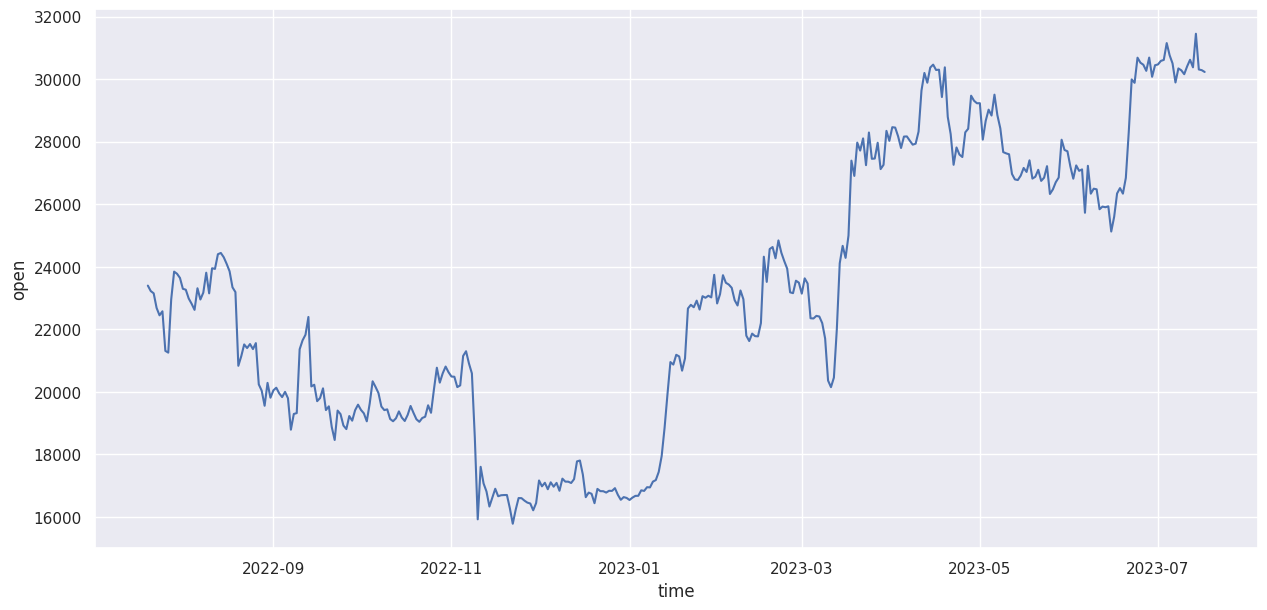

In [109]:
plt.figure(figsize=(15, 7))
sns.lineplot(data=df,x='time',y='open')